用k-means算法时，必须把集群数量当作一个输入参数。在真实世界中，我们事先不知道这个信息，介意搜索集群数量的参数空间，
通过轮廓系数得分找到最优集群数量。但这是一个非常耗时的过程。     
而DBSCAN(Desity-Based Spatial Clustering of Application With Noise,带噪声的基于密度的聚类方法)是一种可以直接找出集群数量的方法。    
DBSCAN将数据点看成是紧密集群的若干组。如果某点属于一个集群，那么就应该有许多点也属于同一个集群。该方法里面有一个epsilon参数，可以
控制这个点到其他点的最大距离。如果两个点的距离超过了参数epsilon的值，它们就不可能在一个集群中。     
这种方法的主要优点是它可以处理异常点，如果有一些点位于数据稀疏区域，DBSCAN就会把这些点作为异常点，而不会强制将它们放入一个集群中。

Epsilon: 0.3 -->sihouette score: 0.1287
Epsilon: 0.4 -->sihouette score: 0.3594
Epsilon: 0.5 -->sihouette score: 0.5134
Epsilon: 0.6 -->sihouette score: 0.6165
Epsilon: 0.7 -->sihouette score: 0.6322
Epsilon: 0.8 -->sihouette score: 0.6366
Epsilon: 0.9 -->sihouette score: 0.5142
Epsilon: 1.0 -->sihouette score: 0.5629
Epsilon: 1.1 -->sihouette score: 0.5629
Epsilon: 1.2 -->sihouette score: 0.5629
Best epislon =  0.8


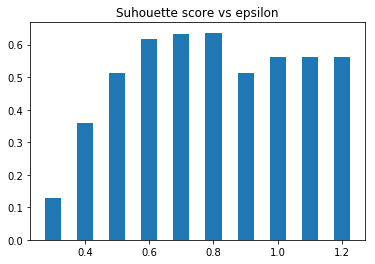

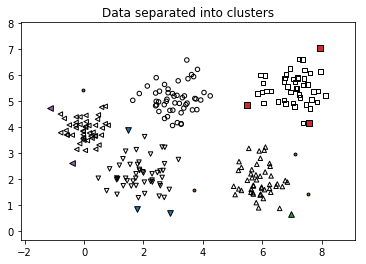

In [36]:
import warnings
warnings.filterwarnings("ignore")

from itertools import cycle
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt

def txt_read(filename,delim):
    x_data = []
    with open(filename,'r') as f:
        for line in f:
#             data = line.strip().split(delim)
            data = [float(x) for x in line.strip().split(delim)]
            x_data.append(data)

    x_data = np.array(x_data)
    return x_data

data = txt_read('data_perf.txt',',')

# 寻找最优的epsilon参数值
eps_grid = np.linspace(0.3,1.2,num=10)
sihouette_scores = []
eps_best = -1
score_best = -1
model_best = None
labels_best = None

# 搜索参数空间：
for eps in eps_grid:
    # 训练DBSCAN聚类模型
    model = DBSCAN(eps=eps,min_samples=5).fit(data)   
    # 提取标记
    labels = model.labels_
    # 提取性能指标
    score = round(metrics.silhouette_score(data,labels),4)
    sihouette_scores.append(score)
    print('Epsilon:',round(eps,2),'-->sihouette score:',score)
    # 保存指标的最佳得分和对应的epsilon值
    if score > score_best:
        score_best = score
        eps_best = eps
        model_best = model
        labels_best = labels
        
plt.figure()
plt.bar(eps_grid,sihouette_scores,width=0.05,align='center')
plt.title('Suhouette score vs epsilon')
print('Best epislon = ',round(eps_best,2))

# 有些数据点还没有分配集群，我们需要识别它们
# 检查标记中没有分配集群的数据点
offset = 0
if -1 in labels_best:
    offset = 1
# 提取集群的数量
num_clusters = len(set(labels_best)) - offset
# 提取核心样本
# 从训练模型中提取核心样本的数据点索引
mask_core = np.zeros(labels_best.shape,dtype=np.bool)
mask_core[model_best.core_sample_indices_] = True
# core_sample_indices_ : 核心点的索引
# 因为labels_不能区分核心点还是边界点，所以需要用这个索引确定核心点


# 将集群结果可视化
# 首先提取独特的标记集合，然后分配不同的标记
plt.figure()
labels_uniq = set(labels_best)
markers = 'vo^s<>'
# 用迭代法把每个集群的数据点用不同的标记画出来
for cur_label,marker in zip(labels_uniq,markers):
    if cur_label == -1:
        marker = '.'
        
    cur_mask = (labels_best == cur_label)
    
    cur_data = data[cur_mask & mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
             edgecolors='black', s=20, facecolors='none')

    cur_data = data[cur_mask &  ~mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
             edgecolors='black', s=32)

    
x_min,x_max = min(data[:,0])-1,max(data[:,0])+1
y_min,y_max = min(data[:,1])-1,max(data[:,1])+1
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
# plt.xticks(np.arange(x_min,x_max,1))
# plt.yticks(np.arange(y_min,y_max,1))
plt.title('Data separated into clusters')
plt.show()